<a href="https://colab.research.google.com/github/MJAHMADEE/Convolutional_Neural_Network/blob/main/CNN_Training_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**GPU**

In [2]:
!nvidia-smi

Thu Apr 13 09:51:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Install**

In [3]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 8.3 MB/s eta 0:00:00


# **Imports 📢**

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

import torchvision

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

from torchmetrics import Accuracy
from tqdm import tqdm

# **Dataset 🗂️**

## Transform

In [5]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Load the MNIST dataset from an online URL
mnist_train = datasets.MNIST(root='https://www.example.com/mnist', train=True, download=True, transform=transforms.ToTensor())

# Compute the mean and standard deviation of the dataset
train_mean = torch.mean(mnist_train.data / 255.0)
train_std = torch.std(mnist_train.data / 255.0)

print("Mean: ", train_mean)
print("Std: ", train_std)


100%|██████████| 9912422/9912422 [00:00<00:00, 105690570.87it/s]


Extracting https://www.example.com/mnist/MNIST/raw/train-images-idx3-ubyte.gz to https://www.example.com/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 93396834.10it/s]


Extracting https://www.example.com/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to https://www.example.com/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26747620.08it/s]


Extracting https://www.example.com/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to https://www.example.com/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19619494.10it/s]


Extracting https://www.example.com/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to https://www.example.com/mnist/MNIST/raw

Mean:  tensor(0.1307)
Std:  tensor(0.3081)


In [6]:
transform_train = transforms.Compose([
    # transforms.Resize((32, 32)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)) # Repeat grayscale channel 3 times to get RGB
])


transform_test = transforms.Compose([
    # transforms.Resize((32, 32)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)) # Repeat grayscale channel 3 times to get RGB
])



## MNIST Dataset

In [7]:
train_set = datasets.MNIST('https://www.example.com/mnist', train=True, transform = transform_train, download=True)

test_set = datasets.MNIST('https://www.example.com/mnist', train=False, transform = transform_test, download=True)

## DataLoader

In [8]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [9]:
x, y = next(iter(train_loader))
print(x.shape)
print(y)

torch.Size([64, 3, 28, 28])
tensor([3, 4, 2, 4, 0, 6, 1, 9, 3, 4, 2, 2, 5, 7, 0, 5, 3, 7, 2, 0, 9, 3, 3, 8,
        4, 6, 2, 5, 7, 4, 1, 4, 2, 6, 9, 1, 5, 6, 8, 7, 2, 2, 4, 0, 9, 7, 2, 6,
        6, 4, 4, 9, 0, 1, 9, 2, 7, 2, 4, 0, 0, 3, 4, 1])


## Visualize

In [10]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

def plot_images(images, labels, classes, normalize=True):
  n_images = len(images)

  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure(figsize=(10, 10))

  for i in range(rows*cols):

    ax = fig.add_subplot(rows, cols, i+1)
    
    image = images[i]
    if normalize:
      image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(classes[labels[i]])
    ax.axis('off')

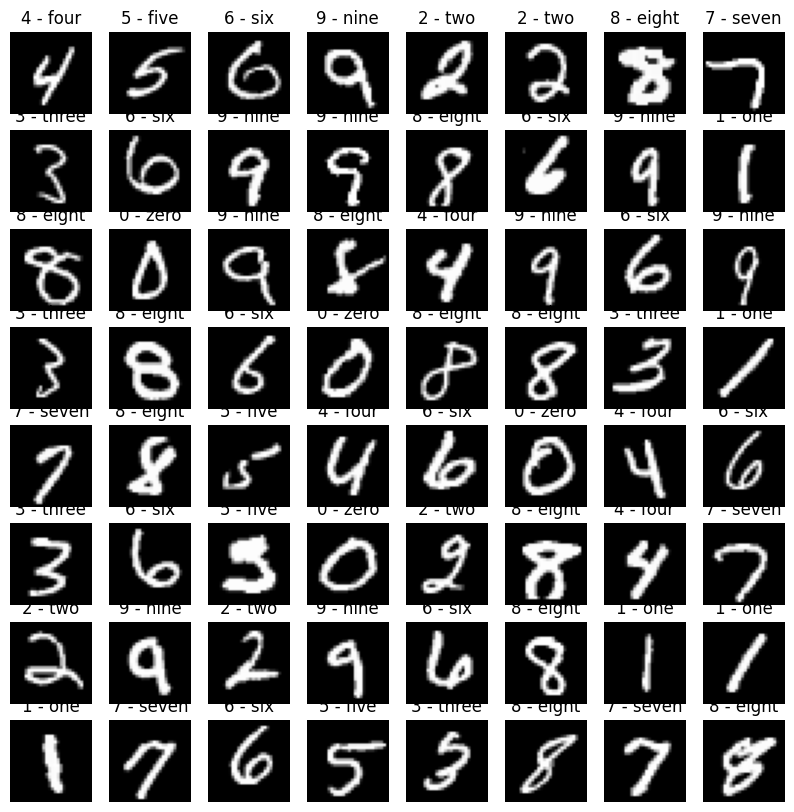

In [11]:
batch = next(iter(train_loader))
classes = train_set.classes
plot_images(batch[0], batch[1], classes)

# **Model 🧠**

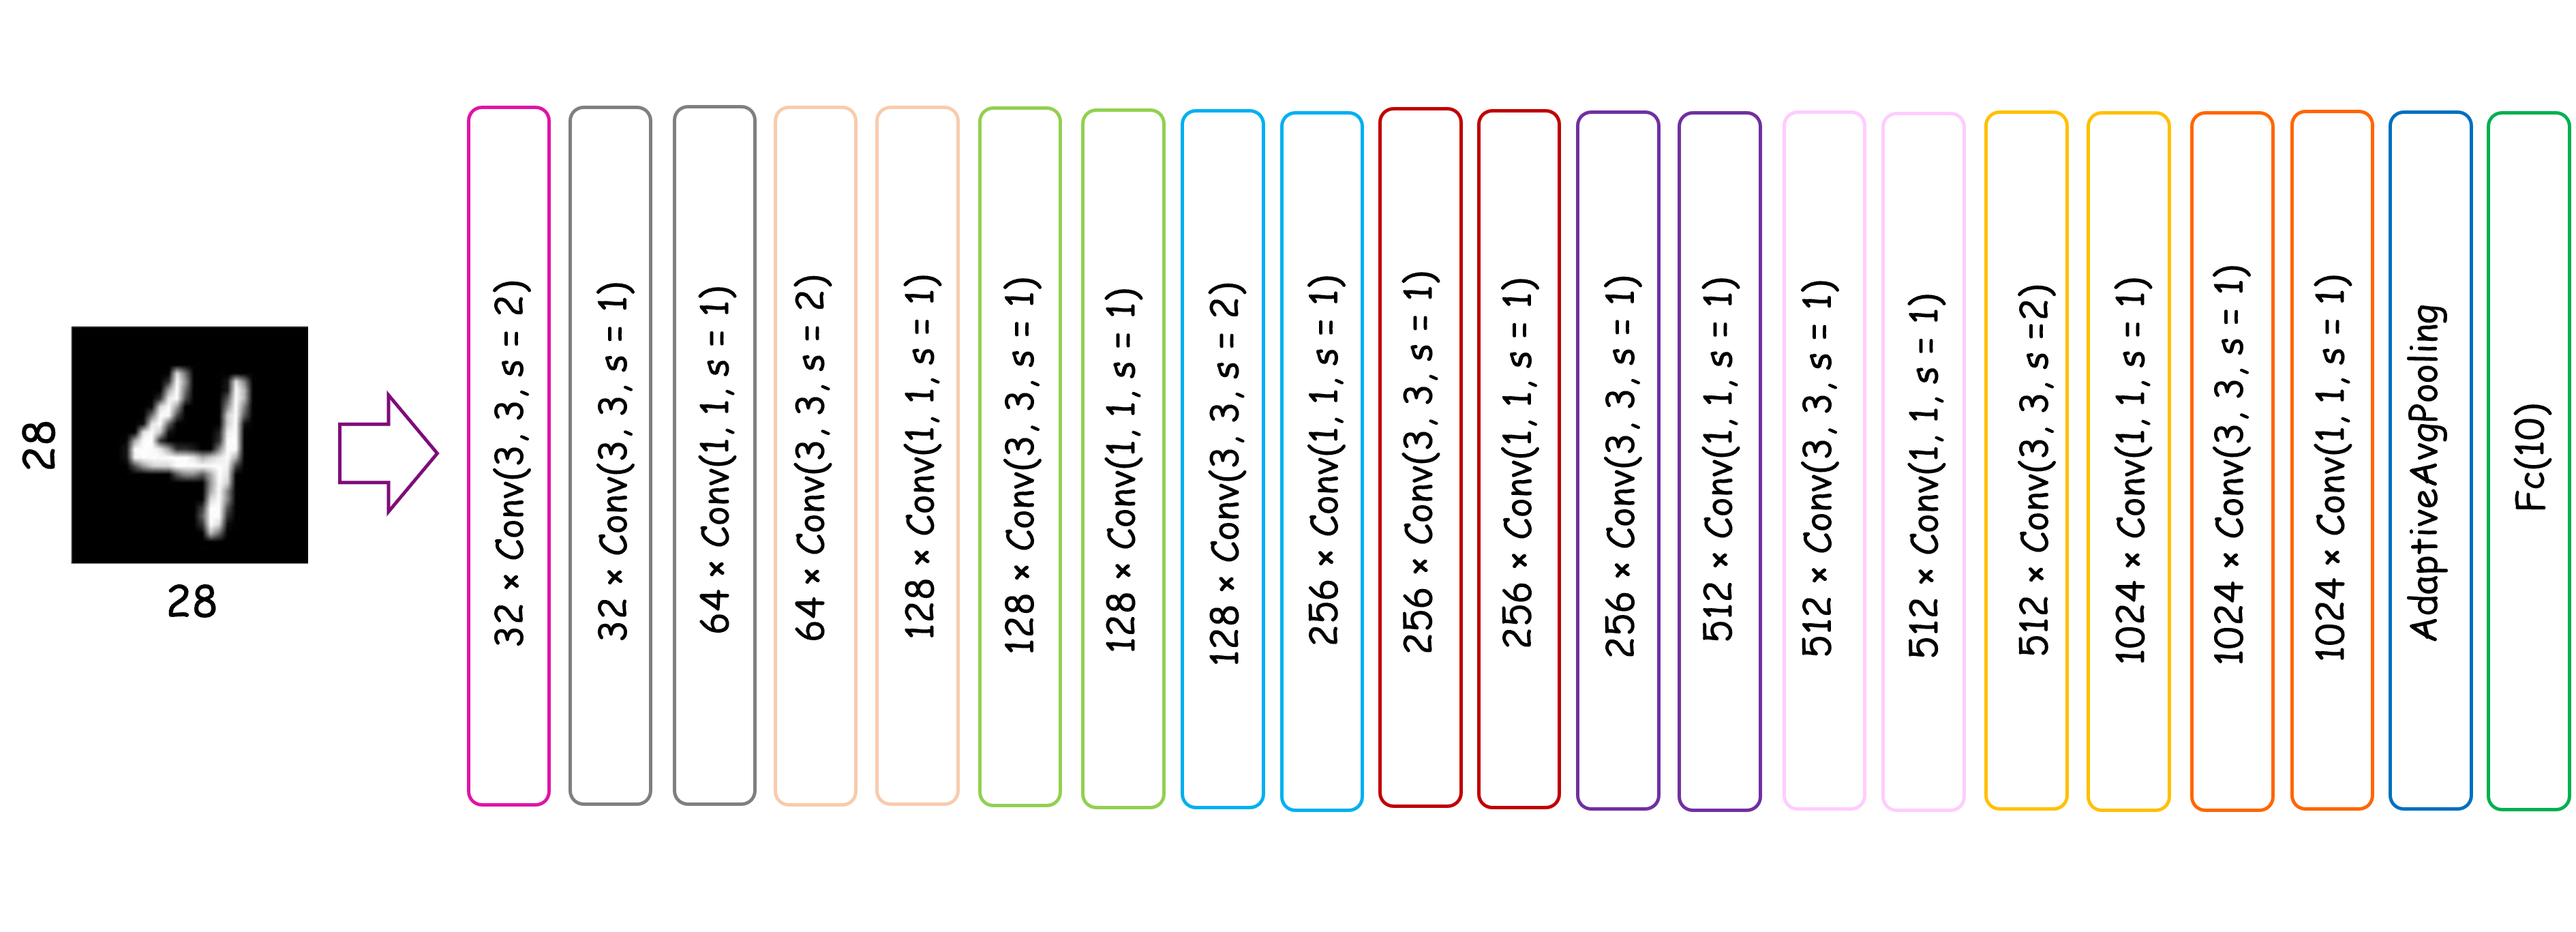

In [12]:
import torch
import torch.nn as nn

def CNN():
    network = nn.Sequential(
        nn.Conv2d(3, 32, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 32, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, 1, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 128, 1, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(128, 128, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, 1, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(128, 128, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 256, 1, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(256, 256, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, 1, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(256, 256, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 512, 1, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(512, 512, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(512, 512, 1, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(512, 512, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(512, 1024, 1, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(1024, 1024, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(1024, 1024, 1, stride=1, padding=0),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(1024, 10)
    )
    
    return network


In [13]:
model = CNN()

In [14]:
model(torch.randn(10, 3, 32, 32)).shape

torch.Size([10, 10])

In [15]:
def num_params(model):
  nums = sum(p.numel() for p in model.parameters())/1e6
  return nums

In [16]:
num_params(model)

17.785386

# **Device ⚙️**

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)

In [18]:
device

'cuda'

# **Loss & Optimizer ⚖️**

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# **Utils 🧰**

In [20]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Functions** 🧮

In [21]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy().to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      loss = loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg, 
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [22]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy().to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      
      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

In [27]:
from torchmetrics import Accuracy

def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(num_classes=10, task='multiclass').to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      loss = loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets)
      tepoch.set_postfix(loss=loss_train.avg, 
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(num_classes=10, task='multiclass').to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      
      loss_valid.update(loss.item())
      acc_valid(outputs, targets)
  return loss_valid.avg, acc_valid.compute().item()


# **Efficient way for set hyperparams 🔨**

## Step 1: check forward path

Calculate loss for one batch

In [23]:
x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(2.3034, device='cuda:0', grad_fn=<NllLossBackward0>)


## Step 2: check backward path

Select 5 random batches and train the model

In [30]:
_, mini_train_dataset = random_split(train_set, (len(train_set)-100, 100))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [31]:
num_epochs = 10
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 9: 100%|██████████| 5/5 [00:00<00:00, 37.56batch/s, accuracy=13, loss=2.29]


## Step 3: select best lr

Train all data for one epoch

In [32]:
num_epochs = 2
for lr in [0.1, 0.01]:
  print(f'LR={lr}')
  model = CNN().to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
  print()

LR=0.1


Epoch 1: 100%|██████████| 938/938 [00:42<00:00, 21.86batch/s, accuracy=11.2, loss=2.3]



LR=0.01


Epoch 1: 100%|██████████| 938/938 [00:42<00:00, 21.95batch/s, accuracy=11.2, loss=2.3]

## Step 4: small grid (optional)

Create a small grid based on the WD and the best LR



In [35]:
num_epochs = 1

for lr in [0.09, 0.1]:
  for wd in [1e-4, 1e-5, 0.]:
    model = CNN().to(device)   
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    print(f'LR={lr}, WD={wd}')

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    print()

LR=0.09, WD=0.0001


Epoch 0: 100%|██████████| 938/938 [00:43<00:00, 21.72batch/s, accuracy=11.1, loss=2.3]



LR=0.09, WD=1e-05


Epoch 0: 100%|██████████| 938/938 [00:43<00:00, 21.70batch/s, accuracy=11.2, loss=2.3]



LR=0.09, WD=0.0


Epoch 0: 100%|██████████| 938/938 [00:42<00:00, 22.14batch/s, accuracy=11.1, loss=2.3]



LR=0.1, WD=0.0001


Epoch 0: 100%|██████████| 938/938 [00:42<00:00, 21.89batch/s, accuracy=11.1, loss=2.3]



LR=0.1, WD=1e-05


Epoch 0: 100%|██████████| 938/938 [00:43<00:00, 21.66batch/s, accuracy=11.1, loss=2.3]



LR=0.1, WD=0.0


Epoch 0: 100%|██████████| 938/938 [00:42<00:00, 22.22batch/s, accuracy=11.1, loss=2.3]

## Step 5: train more epochs

In [36]:
model = CNN().to(device)

In [37]:
lr = 0.09
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

In [38]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [39]:
num_epochs = 2

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model, 
                                                 train_loader, 
                                                 loss_fn, 
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)
  
  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)
  
  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 938/938 [00:43<00:00, 21.56batch/s, accuracy=11.1, loss=2.3]


Valid: Loss = 2.301, Acc = 0.1135



Epoch 1: 100%|██████████| 938/938 [00:42<00:00, 21.82batch/s, accuracy=11.2, loss=2.3]


Valid: Loss = 2.301, Acc = 0.1135



# **Plot 📈**

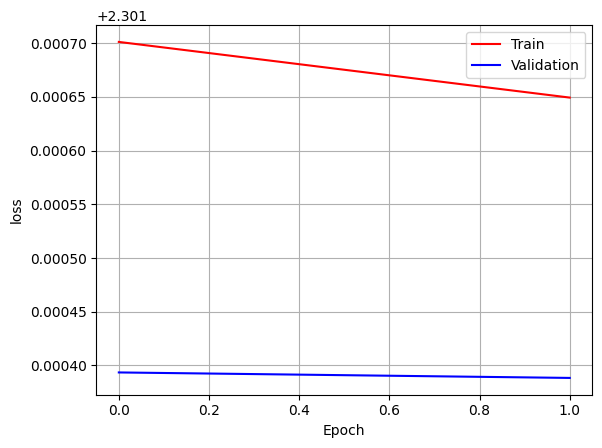

In [40]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

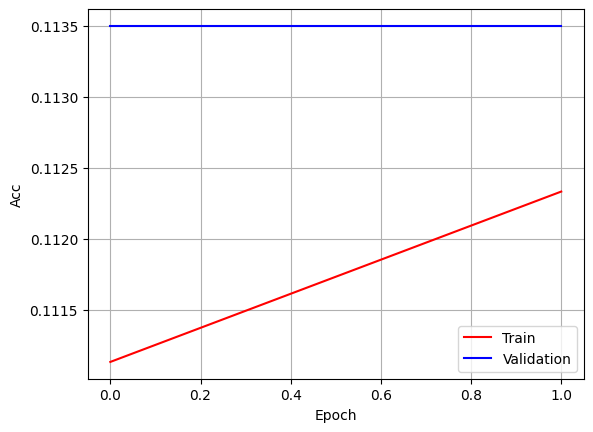

In [41]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

# **Save 💰**

In [42]:
torch.save(model, f'final_model.pt')